In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from func.assets import *
from func.ballistic_tables import load_ballistic_tables
from func.drag import init_drag_tables, available_drag_models
from func.solver import SolverConfig, solve_scenario_external_ballistics_only

In [2]:
def interpolate_trajectory(
    data_file: str,
    sample_by: str = 'distance',
    sample_number: int = 100,
    stop: float = None
) -> pd.DataFrame:
  """
  Интерполирует траекторные данные из CSV и возвращает равномерно распределённые точки.

  Параметры:
    data_file (str): путь к CSV-файлу с колонками: x_m, z_m, speed_mps, t_s
    sample_by (str): по какой переменной делать равномерную дискретизацию.
                     Возможные значения: 'distance', 'speed', 'time', 'drop'
    sample_number (int): количество точек в выходном наборе
    stop (float/int): конечное значение для интерполяции.
                      Если положительное — интерполируется от 0 до stop.
                      Если отрицательное — от stop до 0.

  Возвращает:
    pd.DataFrame с колонками: x_m, z_m, speed_mps, t_s
  """
  # Загрузка данных
  df = pd.read_csv(data_file)

  # Определение входной и выходных переменных
  mapping = {
    'distance': ('x_m', ['z_m', 'speed_mps', 't_s']),
    'speed': ('speed_mps', ['x_m', 'z_m', 't_s']),
    'time': ('t_s', ['x_m', 'z_m', 'speed_mps']),
    'drop': ('z_m', ['x_m', 'speed_mps', 't_s'])
  }

  if sample_by not in mapping:
    raise ValueError("sample_by must be one of: 'distance', 'speed', 'time', 'drop'")

  x_col, y_cols = mapping[sample_by]

  # Определение диапазона интерполяции
  x_min = df[x_col].min()
  x_max = df[x_col].max()

  if stop is None:
    stop = x_max

  if stop >= 0:
    start_val = 0.0
    end_val = float(stop)
  else:
    start_val = float(stop)
    end_val = 0.0

  # Проверка, что диапазон внутри или частично перекрывается данными
  if start_val < x_min or end_val > x_max:
    raise ValueError(f"Requested range [{start_val}, {end_val}] exceeds data bounds [{x_min}, {x_max}] for column '{x_col}'")

  # Создание равномерной сетки
  x_new = np.linspace(start_val, end_val, sample_number)

  # Интерполяция каждой выходной колонки
  interp_data = {x_col: x_new}
  for col in y_cols:
    interp_func = lambda x, xp=df[x_col], fp=df[col]: np.interp(x, xp, fp)
    interp_data[col] = interp_func(x_new)

  # Сборка результата в правильном порядке
  result_df = pd.DataFrame({
    'x_m': interp_data['x_m'] if 'x_m' in interp_data else np.interp(x_new, df[x_col], df['x_m']),
    'z_m': interp_data['z_m'] if 'z_m' in interp_data else np.interp(x_new, df[x_col], df['z_m']),
    'speed_mps': interp_data['speed_mps'] if 'speed_mps' in interp_data else np.interp(x_new, df[x_col], df['speed_mps']),
    't_s': interp_data['t_s'] if 't_s' in interp_data else np.interp(x_new, df[x_col], df['t_s'])
  })

  return result_df

In [3]:
def fmt_energy_j(e_j: float) -> str:
  e = float(e_j)
  if e >= 1e6:
    return f"{e / 1e6:.3f} MJ"
  if e >= 1e3:
    return f"{e / 1e3:.3f} kJ"
  return f"{e:.3f} J"


def lerp(a: float, b: float, t: float) -> float:
  return a + (b - a) * t


def lerp_color(c0: tuple[float, float, float],
               c1: tuple[float, float, float],
               t: float) -> tuple[float, float, float]:
  t = float(np.clip(t, 0.0, 1.0))
  return (
    lerp(c0[0], c1[0], t),
    lerp(c0[1], c1[1], t),
    lerp(c0[2], c1[2], t),
  )


def mach_to_color(mach: float,
                  *,
                  m_sub_max: float = 1.0,
                  m_sup_max: float = 3.0) -> tuple[float, float, float]:
  # Дозвук: синий -> фиолетовый
  sub0 = mcolors.to_rgb('#2a6fdb')  # blue
  sub1 = mcolors.to_rgb('#7a2adb')  # violet

  # Сверхзвук: оранжевый -> красный
  sup0 = mcolors.to_rgb('#ff8c1a')  # orange
  sup1 = mcolors.to_rgb('#e0002a')  # red

  m = float(mach)
  if m < 1.0:
    t = m / max(m_sub_max, 1e-9)
    return lerp_color(sub0, sub1, t)
  t = (m - 1.0) / max(m_sup_max - 1.0, 1e-9)
  return lerp_color(sup0, sup1, t)

In [4]:
paths = AssetPaths(Path('.'))
scenario = load_scenario(paths, 'demo-1.yaml')
weapon = load_weapon(paths, scenario.weapon.id)
ammo = load_ammo(paths, scenario.ammo.id)
medium = load_medium(paths, scenario.environment.medium)

In [5]:
tables = load_ballistic_tables('model/ballistic.yaml')
init_drag_tables(tables)

available_drag_models()

['G1', 'G2', 'G7', 'Rod', 'Sphere']

In [6]:
gravity = 9.79342  # Houston, TX
solver_config = SolverConfig(dt_s=0.01)

In [7]:
res = solve_scenario_external_ballistics_only(
  scenario=scenario,
  weapon=weapon,
  ammo=ammo,
  medium=medium,
  gravity_mps2=gravity,
  config=solver_config,
)

In [8]:
sample = interpolate_trajectory(
  data_file='sample/m855_62gr.csv',
  sample_by='distance',
  sample_number=32
)
sample

,x_m,z_m,speed_mps,t_s
0,0.000000,0.000000,910.000000,0.000000
1,19.354839,-0.006581,890.645161,0.021290
2,38.709677,-0.013161,871.290323,0.042581
3,58.064516,-0.024742,852.258065,0.064355
4,77.419355,-0.043323,833.677419,0.086806
5,96.774194,-0.061903,815.096774,0.109258
6,116.129032,-0.090806,797.161290,0.132677
7,135.483871,-0.121774,779.354839,0.156290
8,154.838710,-0.156129,761.741935,0.180194
9,174.193548,-0.200645,744.709677,0.204968


In [9]:
display(f"Stop reason: {res.meta.stop_reason}")
res.trajectory

'Stop reason: max_distance'

,t_s,x_m,y_m,z_m,drop_m,vx_mps,vy_mps,vz_mps,speed_mps,rel_speed_mps,mach,energy_j
0,0.00,0.000000,0.0,0.000000,-0.000000,910.000000,0.0,0.000000,910.000000,905.500000,2.637942,1656.200000
1,0.01,9.044657,0.0,-0.000488,0.000488,898.976339,0.0,-0.097338,898.976344,894.476344,2.605827,1616.316934
2,0.02,17.980411,0.0,-0.001943,0.001943,888.217856,0.0,-0.193513,888.217877,883.717877,2.574485,1577.861993
3,0.03,26.809866,0.0,-0.004354,0.004354,877.715096,0.0,-0.288565,877.715143,873.215144,2.543888,1540.767746
4,0.04,35.535535,0.0,-0.007711,0.007711,867.459049,0.0,-0.382535,867.459133,862.959134,2.514010,1504.970696
...,...,...,...,...,...,...,...,...,...,...,...,...
241,2.41,992.399167,0.0,-19.147649,19.147649,230.417653,0.0,-15.310219,230.925740,226.435838,0.659663,106.653395
242,2.42,994.700826,0.0,-19.301069,19.301069,229.914451,0.0,-15.373943,230.427891,225.938118,0.658213,106.194026
243,2.43,996.997466,0.0,-19.455127,19.455127,229.414096,0.0,-15.437642,229.932921,225.443277,0.656771,105.738296
244,2.44,999.289117,0.0,-19.609822,19.609822,228.916559,0.0,-15.501318,229.440802,224.951290,0.655338,105.286163


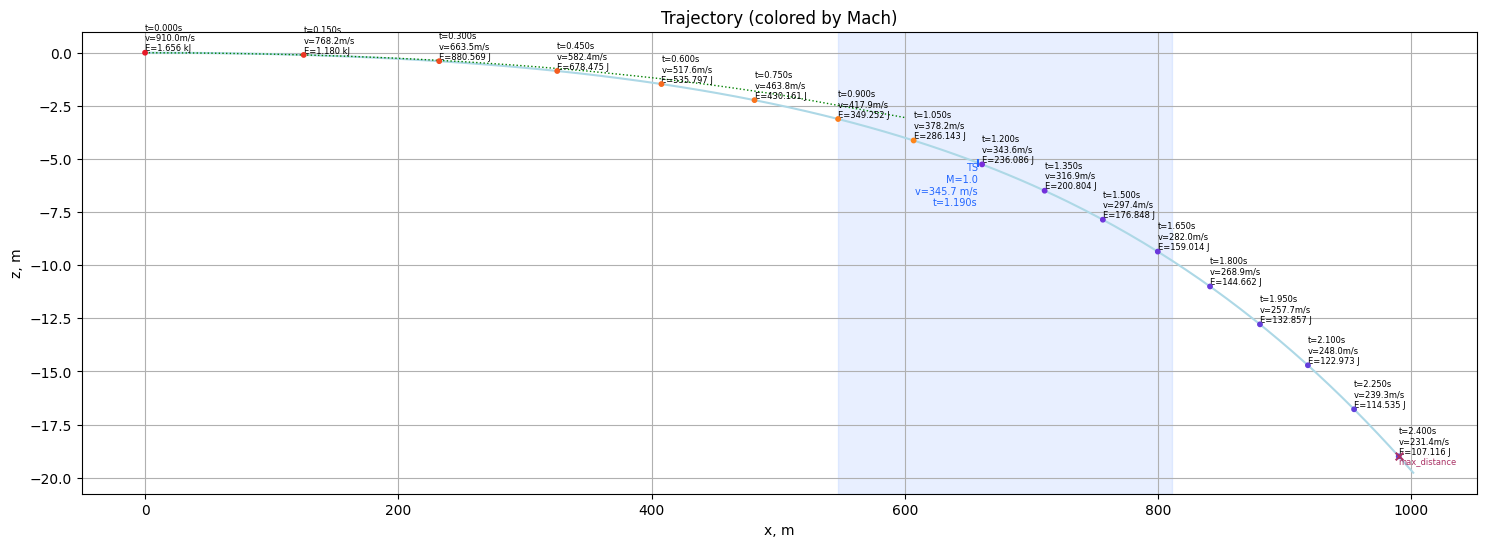

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))

x = res.trajectory['x_m']
y = res.trajectory['z_m']
ax.plot(
  x, y,
  c='lightblue'
)
ax.plot(
  sample['x_m'], sample['z_m'],
  c='green',
  ls=':',
  lw=1,
  alpha=1.0
)
step = 15
df = res.trajectory.iloc[::step].reset_index(drop=True)

mx = df['x_m'].to_numpy(dtype=np.float64)
mz = df['z_m'].to_numpy(dtype=np.float64)
mach = df['mach'].to_numpy(dtype=np.float64)

colors = [mach_to_color(m) for m in mach]

ax.scatter(mx, mz, s=10, c=colors, zorder=10)

# Подписи
for i in range(len(df)):
  t_s = float(df.loc[i, 't_s'])
  v = float(df.loc[i, 'speed_mps'])
  e = float(df.loc[i, 'energy_j'])
  label = f"t={t_s:.3f}s\nv={v:.1f}m/s\nE={fmt_energy_j(e)}"
  ax.text(
    mx[i], mz[i],
    label,
    fontsize=6,
    ha='left',
    va='bottom',
  )

mach_full = res.trajectory['mach'].to_numpy()

ts_idx = None
for i in range(1, len(mach_full)):
  if mach_full[i - 1] >= 1.0 and mach_full[i] < 1.0:
    ts_idx = i
    break

if ts_idx is not None:
  ts_x = res.trajectory.loc[ts_idx, 'x_m']
  ts_z = res.trajectory.loc[ts_idx, 'z_m']
  ts_t = res.trajectory.loc[ts_idx, 't_s']
  ts_v = res.trajectory.loc[ts_idx, 'speed_mps']

  ax.scatter(
    [ts_x], [ts_z],
    s=30,
    c='#26f',
    marker='|',
    zorder=20,
  )
  ax.text(
    ts_x, ts_z,
    f"TS\nM=1.0\nv={ts_v:.1f} m/s\nt={ts_t:.3f}s",
    fontsize=7,
    ha='right',
    va='top',
    color='#26f',
  )
ax.axvspan(
  res.trajectory.loc[mach_full > 1.2, 'x_m'].max(),
  res.trajectory.loc[mach_full < 0.8, 'x_m'].min(),
  color='#26f',
  alpha=0.1,
  zorder=0,
)

last_x, last_y = df.iloc[-1][['x_m', 'z_m']]
ax.scatter(
  [last_x], [last_y],
  s=30,
  c='#a36',
  marker='x',
  zorder=20
)
ax.text(
  last_x, last_y,
  res.meta.stop_reason,
  fontsize=6,
  c='#a36',
  ha='left',
  va='top'
)
ax.set_xlabel('x, m')
ax.set_ylabel('z, m')
ax.set_title('Trajectory (colored by Mach)')
ax.grid(True)
# ax.set_aspect('equal', adjustable='box')

In [11]:
res.trajectory[['x_m', 'z_m', 'speed_mps', 't_s']][::10].to_csv('./output/m855_demo-1.csv', float_format='%.3f', index=False)